# Importing Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import chi2

# Loading Data

In [5]:
# URL of the dataset
url = "https://faculty.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts3/m-ibm3dx2608.txt"

# Load the dataset
df = pd.read_csv(url, delim_whitespace=True)

# Convert date column
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

# Show the first few rows
print(df.head())

/tmp/ipython-input-106237868.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True)


        date    ibmrtn     vwrtn     ewrtn     sprtn
0 1926-01-30 -0.010381  0.000724  0.023174  0.022472
1 1926-02-27 -0.024476 -0.033374 -0.053510 -0.043956
2 1926-03-31 -0.115591 -0.064341 -0.096824 -0.059113
3 1926-04-30  0.089783  0.038358  0.032946  0.022688
4 1926-05-28  0.036932  0.012172  0.001035  0.007679


# Graph of Simple Returns

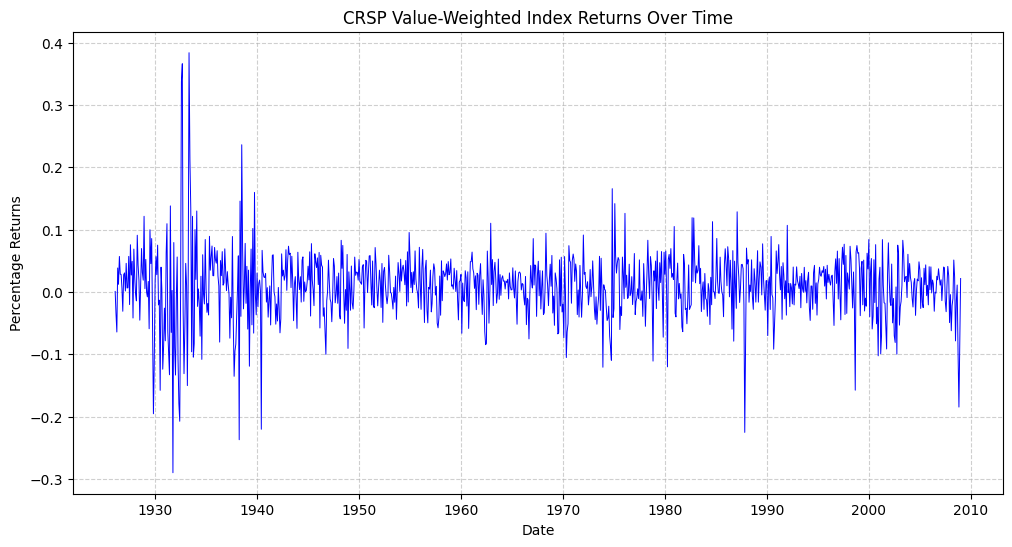

In [6]:
vw = df["vwrtn"]  # CRSP Value-Weighted Index simple returns

plt.figure(figsize=(12,6))
plt.plot(df["date"], vw, color="blue", linewidth=0.7)
plt.title("CRSP Value-Weighted Index Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Percentage Returns")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# AR Order Selection

In [32]:
# Automatically select the best AR lag up to maxlag=12 using AIC
sel = ar_select_order(vw, maxlag=12, ic='aic', trend='c')

# Best AR order
print("Selected AR order:", sel.ar_lags)

Selected AR order: [1, 2, 3, 4, 5, 6, 7, 8, 9]


# Model Fit

In [8]:
# Fit AR(9) model

ar_model = AutoReg(vw, lags=sel.ar_lags, trend='c').fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  vwrtn   No. Observations:                  996
Model:                     AutoReg(9)   Log Likelihood                1492.296
Method:               Conditional MLE   S.D. of innovations              0.053
Date:                Thu, 25 Sep 2025   AIC                          -2962.591
Time:                        10:48:20   BIC                          -2908.750
Sample:                             9   HQIC                         -2942.115
                                  996                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.002      3.814      0.000       0.004       0.011
vwrtn.L1       0.1163      0.032      3.660      0.000       0.054       0.179
vwrtn.L2      -0.0116      0.032     -0.363      0.7

# AR(3) Model Fit

In [12]:
# Fit AR(3) model
ar3_model = ARIMA(vw, order=(3,0,0)).fit()

# Show model summary (coefficients, sigma^2, AIC, etc.)
print(ar3_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  vwrtn   No. Observations:                  996
Model:                 ARIMA(3, 0, 0)   Log Likelihood                1500.863
Date:                Thu, 25 Sep 2025   AIC                          -2991.727
Time:                        10:50:51   BIC                          -2967.208
Sample:                             0   HQIC                         -2982.406
                                - 996                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0090      0.002      5.103      0.000       0.006       0.012
ar.L1          0.1157      0.019      6.139      0.000       0.079       0.153
ar.L2         -0.0186      0.021     -0.892      0.3

# Residual S.E. and Ljung-Box test

In [13]:
resid_se = np.sqrt(np.var(ar3_model.resid, ddof=3))  # ddof = number of AR params
print("Residual Std. Error:", resid_se)

Residual Std. Error: 0.053700514787656715


If this standard error is small relative to the scale of the data, the model is making relatively precise predictions.

However, if the residual standard error is large, it suggests that the model is not fully capturing the underlying patterns, and additional refinements (e.g., adding more lags, differencing, or checking for heteroskedasticity) may be needed.


In [14]:
# Perform Ljung-Box test on AR(3) residuals for lag=12
ljung = acorr_ljungbox(ar3_model.resid, lags=[12], return_df=True)
print(ljung)

      lb_stat  lb_pvalue
12  16.351507   0.175662


The Box-Ljung test is used to check whether the residuals of a time series model exhibit autocorrelation. The null hypothesis of the test states that the residuals are independent (i.e., no autocorrelation), while the alternative hypothesis suggests that autocorrelation is present.

# AR(3) Simplified Model

In [16]:
# Fit AR(1) and AR(3), skipping AR(2)
ar_fixed_model = AutoReg(vw, lags=[1,3], trend='c').fit()
print(ar_fixed_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  vwrtn   No. Observations:                  996
Model:              Restr. AutoReg(3)   Log Likelihood                1495.808
Method:               Conditional MLE   S.D. of innovations              0.054
Date:                Thu, 25 Sep 2025   AIC                          -2983.616
Time:                        10:51:25   BIC                          -2964.013
Sample:                             3   HQIC                         -2976.163
                                  996                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0090      0.002      5.141      0.000       0.006       0.012
vwrtn.L1       0.1126      0.031      3.595      0.000       0.051       0.174
vwrtn.L3      -0.1064      0.032     -3.371      0.0

# Residual S.E. and Ljung-Box test



In [17]:
resid_se_fixed = np.std(ar_fixed_model.resid, ddof=len(ar_fixed_model.params)-1)
print("Residual Std. Error (fixed model):", resid_se_fixed)

Residual Std. Error (fixed model): 0.05370318866100016


In [18]:
ljung_fixed = acorr_ljungbox(ar_fixed_model.resid, lags=[12], return_df=True)
print(ljung_fixed)

      lb_stat  lb_pvalue
12  17.039259   0.148126


# Adj Ljung-Box Test

In [19]:
# 1) Original AR(3) model
ljung_original = acorr_ljungbox(ar3_model.resid, lags=[12], return_df=True)
print("Original Ljung-Box test (AR3):")
print(ljung_original)

# Adjusted p-value
Q_stat_orig = ljung_original['lb_stat'].iloc[0]  # take lag 1 or sum multiple lags if needed
h = 12      # number of lags tested
p_orig = 3  # AR parameters estimated (AR1, AR2, AR3)
df_adj_orig = h - p_orig

p_value_adj_orig = 1 - chi2.cdf(Q_stat_orig, df=df_adj_orig)
print("Adjusted p-value (AR3):", p_value_adj_orig)


# 2) AR(3) with AR2 fixed to 0
ljung_fixed = acorr_ljungbox(ar_fixed_model.resid, lags=[12], return_df=True)
print("\nLjung-Box test (AR1 + AR3, AR2=0):")
print(ljung_fixed)

# Adjusted p-value
Q_stat_fixed = ljung_fixed['lb_stat'].iloc[0]
p_fixed = 2  # AR parameters estimated (AR1, AR3)
df_adj_fixed = h - p_fixed

p_value_adj_fixed = 1 - chi2.cdf(Q_stat_fixed, df=df_adj_fixed)
print("Adjusted p-value (AR1+AR3):", p_value_adj_fixed)


Original Ljung-Box test (AR3):
      lb_stat  lb_pvalue
12  16.351507   0.175662
Adjusted p-value (AR3): 0.05989428131466201

Ljung-Box test (AR1 + AR3, AR2=0):
      lb_stat  lb_pvalue
12  17.039259   0.148126
Adjusted p-value (AR1+AR3): 0.0734997880541971


# Forecasting

In [20]:
# Forecast origin
forecast_origin = 984

# Training data (up to forecast origin)
train = vw.iloc[:forecast_origin]

# Test data (next 12 months)
test = vw.iloc[forecast_origin:forecast_origin+12]

In [21]:
# Fit AR(3) on training data
ar3_train = ARIMA(train, order=(3,0,0)).fit()

# Print model summary
print(ar3_train.summary())

                               SARIMAX Results                                
Dep. Variable:                  vwrtn   No. Observations:                  984
Model:                 ARIMA(3, 0, 0)   Log Likelihood                1488.853
Date:                Thu, 25 Sep 2025   AIC                          -2967.706
Time:                        10:52:43   BIC                          -2943.247
Sample:                             0   HQIC                         -2958.402
                                - 984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.002      5.506      0.000       0.006       0.013
ar.L1          0.1034      0.019      5.491      0.000       0.067       0.140
ar.L2         -0.0200      0.021     -0.966      0.3

In [22]:
# Forecast next 12 months
forecast = ar3_train.get_forecast(steps=12)

# Forecasted mean values
pred_mean = forecast.predicted_mean

# Standard errors of forecast
pred_se = forecast.se_mean

# 95% confidence intervals
pred_ci = forecast.conf_int()

In [23]:
import pandas as pd
import numpy as np

# Create DataFrame with steps, forecast, SE, and actuals
df_forecast = pd.DataFrame({
    "Step": np.arange(1, 13),
    "Forecast": np.round(pred_mean.values, 3),
    "Std. Error": np.round(pred_se.values, 3),
    "Actual": np.round(test.values, 3)
})

# Display forecast table
print(df_forecast)

    Step  Forecast  Std. Error  Actual
0      1     0.007       0.053  -0.062
1      2     0.016       0.054  -0.022
2      3     0.012       0.054  -0.010
3      4     0.010       0.054   0.051
4      5     0.009       0.054   0.024
5      6     0.009       0.054  -0.079
6      7     0.009       0.054  -0.013
7      8     0.010       0.054   0.011
8      9     0.010       0.054  -0.098
9     10     0.009       0.054  -0.185
10    11     0.009       0.054  -0.085
11    12     0.009       0.054   0.021


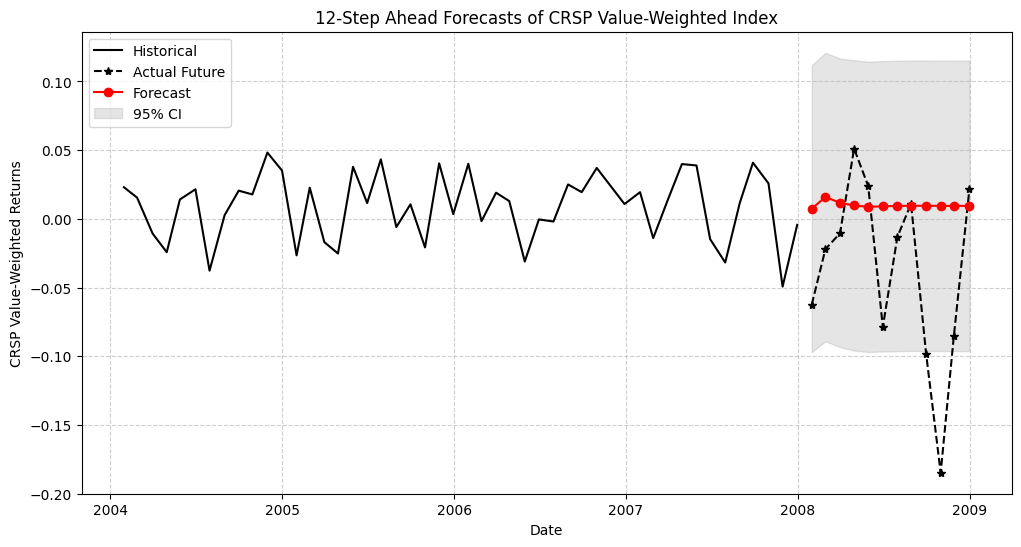

In [25]:
plt.figure(figsize=(12,6))

# Historical data (last 4 years = 48 months)
last_n_months = 48
plot_start = max(0, forecast_origin - last_n_months)
plt.plot(df["date"].iloc[plot_start:forecast_origin],
         vw.iloc[plot_start:forecast_origin],
         color="black", label="Historical")

# Actual future values connected with a dashed line
plt.plot(df["date"].iloc[forecast_origin:forecast_origin+12],
         test,
         color="black", linestyle="--", marker="*", label="Actual Future")

# Forecasted values
plt.plot(df["date"].iloc[forecast_origin:forecast_origin+12],
         pred_mean,
         color="red", marker="o", label="Forecast")

# Confidence interval (gray shaded area)
plt.fill_between(df["date"].iloc[forecast_origin:forecast_origin+12],
                 pred_ci.iloc[:,0],
                 pred_ci.iloc[:,1],
                 color="gray", alpha=0.2, label="95% CI")

plt.xlabel("Date")
plt.ylabel("CRSP Value-Weighted Returns")
plt.title("12-Step Ahead Forecasts of CRSP Value-Weighted Index")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()